# New York Taxi Trip Duration

The goal of this project is to build a model that predicts the total duration of taxi trips in New York City.

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

## Import data

In [2]:
# Google Drive connection
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to data on disk
data_path = '/content/drive/MyDrive/colab/data'

In [4]:
# Path to test and training datasets
train_path = os.path.join(data_path, 'train.csv')
test_path = os.path.join(data_path, 'test.csv')

In [5]:
# Read test and training datasets
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [6]:
# Temperature data
temperature = os.path.join(data_path, 'weather', 'temperature.csv')
temperature_df = pd.read_csv(temperature)
temperature_df = (temperature_df[['datetime', 'New York']]
                  .rename(columns={'New York': 'temperature'}))

In [7]:
# Humidity data
humidity = os.path.join(data_path, 'weather', 'humidity.csv')
humidity_df = pd.read_csv(humidity)
humidity_df = (humidity_df[['datetime', 'New York']]
               .rename(columns={'New York': 'humidity'}))

In [8]:
# Pressure data
pressure = os.path.join(data_path, 'weather', 'pressure.csv')
pressure_df = pd.read_csv(pressure)
pressure_df = (pressure_df[['datetime', 'New York']]
               .rename(columns={'New York': 'pressure'}))

In [9]:
# Wind direction data
wind_direction = os.path.join(data_path, 'weather', 'wind_direction.csv')
wind_direction_df = pd.read_csv(wind_direction)
wind_direction_df = (wind_direction_df[['datetime', 'New York']]
                     .rename(columns={'New York': 'wind_direction'}))

In [10]:
# Wind speed data
wind_speed = os.path.join(data_path, 'weather', 'wind_speed.csv')
wind_speed_df = pd.read_csv(wind_speed)
wind_speed_df = (wind_speed_df[['datetime', 'New York']]
                 .rename(columns={'New York': 'wind_speed'}))

## Data description

### New York taxi dataset

The [main dataset](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data) comes from the Kaggle competition "New York City Taxi Trip Duration". It contains detailed information on taxi trips in New York City.

**File descriptions:**
* train.csv - the training set (contains 1458644 trip records)
* test.csv - the testing set (contains 625134 trip records)

**Data fields:**
* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds

### Weather data

Another [dataset](https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data/data) used in the project is the weather dataset, also from Kaggle. The following dataset contains information about weather conditions in several cities around the world in the years 2012-2017. We will be interested in New Your City.

The data we need comes from multiple files: **`temperature.csv`, `humidity.csv`, `pressure.csv`, `wind_direction.csv`, `wind_speed.csv`**. Each file contains a column with the date and measurements on that date.

The data is measured in the following units:
* Humidity - %.
* Pressure - hPa.
* Temperature - K.
* Wind direction - meteorological degrees.
* Wind speed - m/s.

## Initial observations

In [11]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [13]:
print(f'First date of pickup: {train["pickup_datetime"].min()}')
print(f'Last date of pickup: {train["pickup_datetime"].max()}')

First date of pickup: 2016-01-01 00:00:17
Last date of pickup: 2016-06-30 23:59:39


In [14]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  625134 non-null  object 
 1   vendor_id           625134 non-null  int64  
 2   pickup_datetime     625134 non-null  object 
 3   passenger_count     625134 non-null  int64  
 4   pickup_longitude    625134 non-null  float64
 5   pickup_latitude     625134 non-null  float64
 6   dropoff_longitude   625134 non-null  float64
 7   dropoff_latitude    625134 non-null  float64
 8   store_and_fwd_flag  625134 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


In [16]:
print(f'First date of pickup: {test["pickup_datetime"].min()}')
print(f'Last date of pickup: {test["pickup_datetime"].max()}')

First date of pickup: 2016-01-01 00:00:22
Last date of pickup: 2016-06-30 23:59:58


In [17]:
# Check shapes
print(f'Train rows: {train.shape[0]}, train columns: {train.shape[1]}')
print(f'Test rows: {test.shape[0]}, test columns: {test.shape[1]}')

Train rows: 1458644, train columns: 11
Test rows: 625134, test columns: 9


In [18]:
print(f'Train set ids are unique - {train.id.nunique() == train.shape[0]}')
print(f'Train set and test set do not intersect - {len(np.intersect1d(train["id"].values, test["id"].values)) == 0}')
print(f'Number of missing values in train - {train.isna().sum().sum()}, in test - {test.isna().sum().sum()}')
print(f'Unique values of column store_and_fwd_flag - {set(train["store_and_fwd_flag"].unique()) | set(test["store_and_fwd_flag"].unique())}')

Train set ids are unique - True
Train set and test set do not intersect - True
Number of missing values in train - 0, in test - 0
Unique values of column store_and_fwd_flag - {'Y', 'N'}


In [19]:
# Convert pickup_datetime to datetime object
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

# Extract date
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date

# Convert dropoff_datetime to datetime object
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

# Extract date
train.loc[:, 'dropoff_date'] = train['dropoff_datetime'].dt.date

# Convert Y/N to 1/0 values
train['store_and_fwd_flag'] = 1 * (train['store_and_fwd_flag'].values == 'Y')
test['store_and_fwd_flag'] = 1 * (test['store_and_fwd_flag'].values == 'Y')

In [20]:
# Add new column check_trip_duration (trip duration in seconds)
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())

# Identify rows where the calculated check_trip_duration differs significantly (> 1)
duration_difference = train[np.abs(train['check_trip_duration'].values - train['trip_duration'].values) > 1]
print(f'Duration of trips are consistent - {len(duration_difference) == 0}')

Duration of trips are consistent - True


## Data analysis

In [21]:
# Seaborn plot parameters
sns.set_theme(style='whitegrid', rc={'axes.facecolor': '#f4f4f4'})

### Vendors

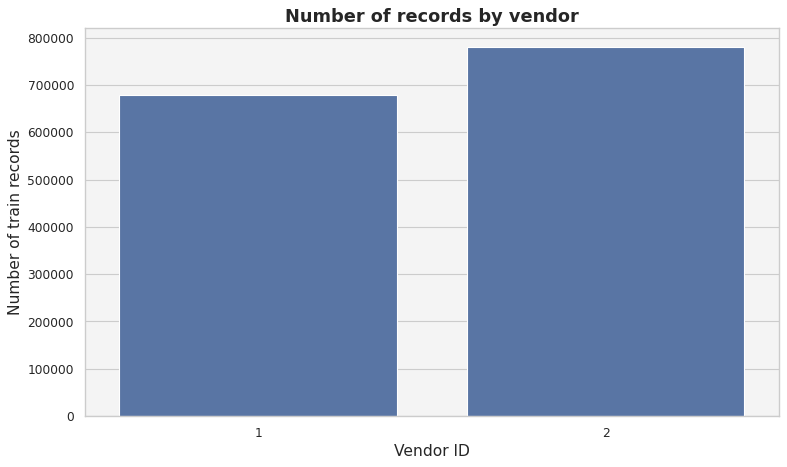

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=80)
sns.barplot(train['vendor_id'].value_counts(), ax=ax)

ax.set_xlabel('Vendor ID', fontsize=14)
ax.set_ylabel('Number of train records', fontsize=14)
ax.set_title('Number of records by vendor', fontweight='bold', fontsize=16)

fig.savefig(os.path.join(data_path, 'images', 'records_vendor.png'))
plt.tight_layout()
plt.show()

There are only 2 vendors. Both vendors share almost the same amount of trips, the difference between two sellers is quite small.

### Trip duration

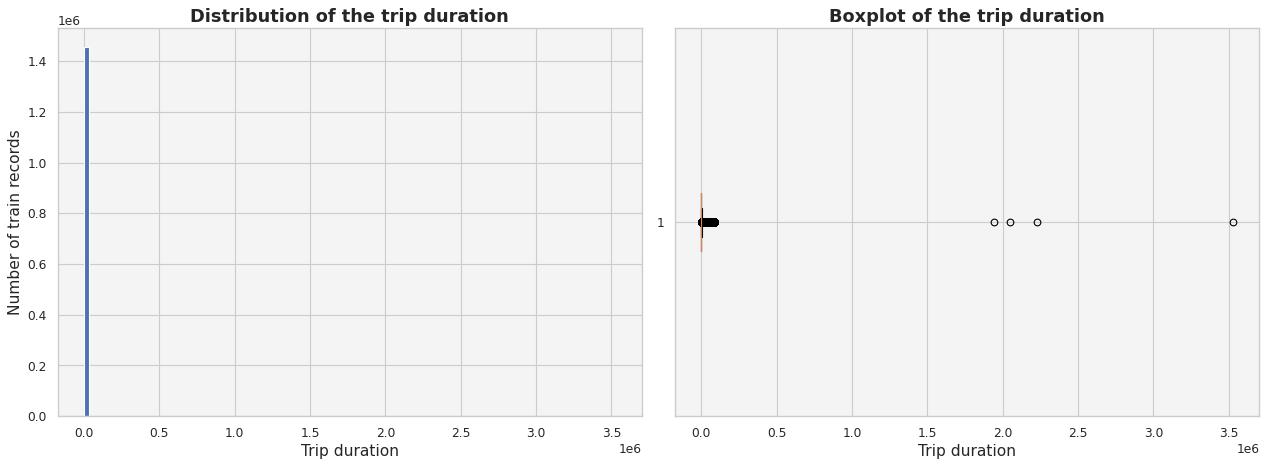

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=80)

ax[0].hist(train['trip_duration'].values, bins=100)
ax[1].boxplot(train['trip_duration'].values, vert=False)

ax[0].set_xlabel('Trip duration', fontsize=14)
ax[0].set_ylabel('Number of train records', fontsize=14)
ax[0].set_title('Distribution of the trip duration', fontweight='bold', fontsize=16)

ax[1].set_xlabel('Trip duration', fontsize=14)
ax[1].set_ylabel(None)
ax[1].set_title('Boxplot of the trip duration', fontweight='bold', fontsize=16)

fig.savefig(os.path.join(data_path, 'images', 'trip_duration.png'))
plt.tight_layout()
plt.show()

In [24]:
print(f'Maximum trip duration - {train["trip_duration"].max()}')

Maximum trip duration - 3526282


In [25]:
print(f'Minimum trip duration - {train["trip_duration"].min()}')

Minimum trip duration - 1


* Maximum trip duration is 3526282, which is more than 40 days. This is clearly an outlier and should be removed.
* There are other outliers as well, about 2 million seconds.
* There are some durations of about 1 second, which probably means that there was no trip at all.

In [26]:
# Groups all trip durations into 1-hour intervals
trip_duration_intervals = (train['trip_duration']
    .groupby(
        pd.cut(train['trip_duration'],
               np.arange(1, max(train['trip_duration']), 3600)),
        observed=False)
    .count()
    .sort_values(ascending=False))
trip_duration_intervals.head()

,trip_duration
trip_duration,
"(1, 3601]",1446313
"(3601, 7201]",10045
"(82801, 86401]",1839
"(7201, 10801]",141
"(79201, 82801]",63


We can see that most trips take 1 hour or less.

In [27]:
print(f'1st percentile - {train["trip_duration"].quantile(0.01)}')
print(f'99nd percentile - {train["trip_duration"].quantile(0.99)}')

1st percentile - 87.0
99nd percentile - 3440.0


We will remove data whose travel time is less than 87 seconds (1 quartile) and more than 3440 seconds (99 quartile).

In [28]:
# Calculate the 1st percentile (1%) and the 99th percentile (99%)
lower_bound = train['trip_duration'].quantile(0.01)
upper_bound = train['trip_duration'].quantile(0.99)

# Remove outliers
train = train[(train['trip_duration'] >= lower_bound) & (train['trip_duration'] <= upper_bound)]

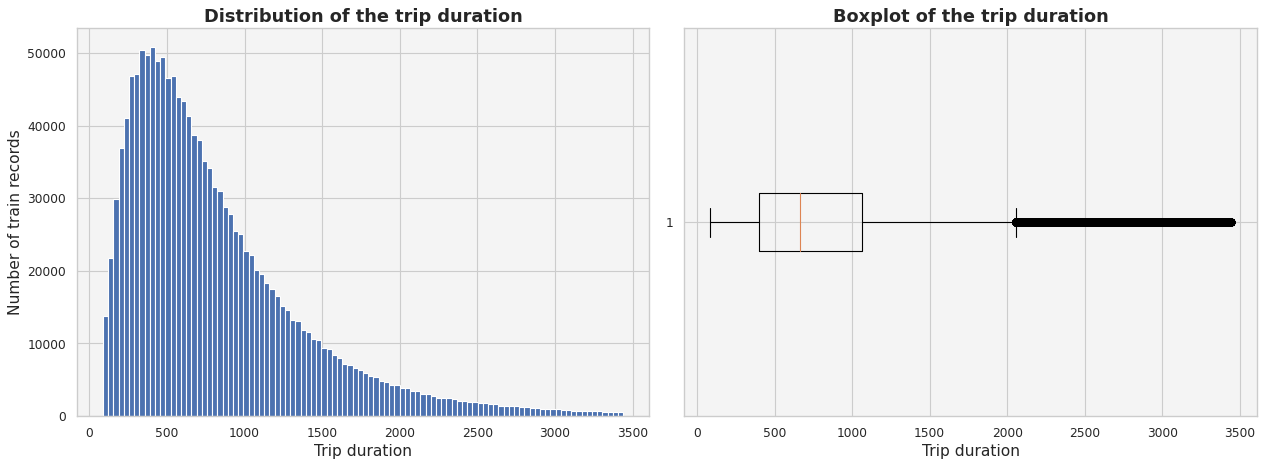

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=80)
ax[0].hist(train['trip_duration'].values, bins=100)
ax[1].boxplot(train['trip_duration'].values, vert=False)

ax[0].set_xlabel('Trip duration', fontsize=14)
ax[0].set_ylabel('Number of train records', fontsize=14)
ax[0].set_title('Distribution of the trip duration', fontweight='bold', fontsize=16)

ax[1].set_xlabel('Trip duration', fontsize=14)
ax[1].set_title('Boxplot of the trip duration', fontweight='bold', fontsize=16)

fig.savefig(os.path.join(data_path, 'images', 'trip_duration2.png'))
plt.tight_layout()
plt.show()

The data is right-skewed. If we apply log transformation, it will normalize the data.

In [30]:
# Take the logarithm of the trip duration
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)

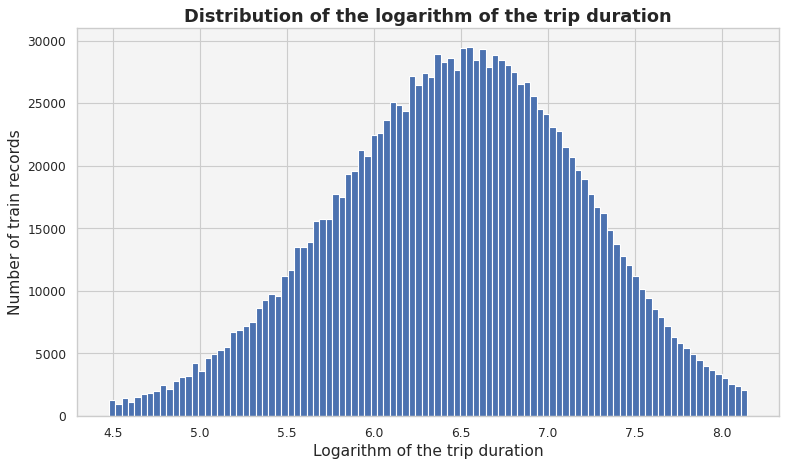

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=80)
ax.hist(train['log_trip_duration'].values, bins=100)

ax.set_xlabel('Logarithm of the trip duration', fontsize=14)
ax.set_ylabel('Number of train records', fontsize=14)
ax.set_title('Distribution of the logarithm of the trip duration', fontweight='bold', fontsize=16)

fig.savefig(os.path.join(data_path, 'images', 'trip_duration_log.png'))
plt.tight_layout()
plt.show()

Now the trip duration is closer to a normal distribution.

### Pickup and dropoff

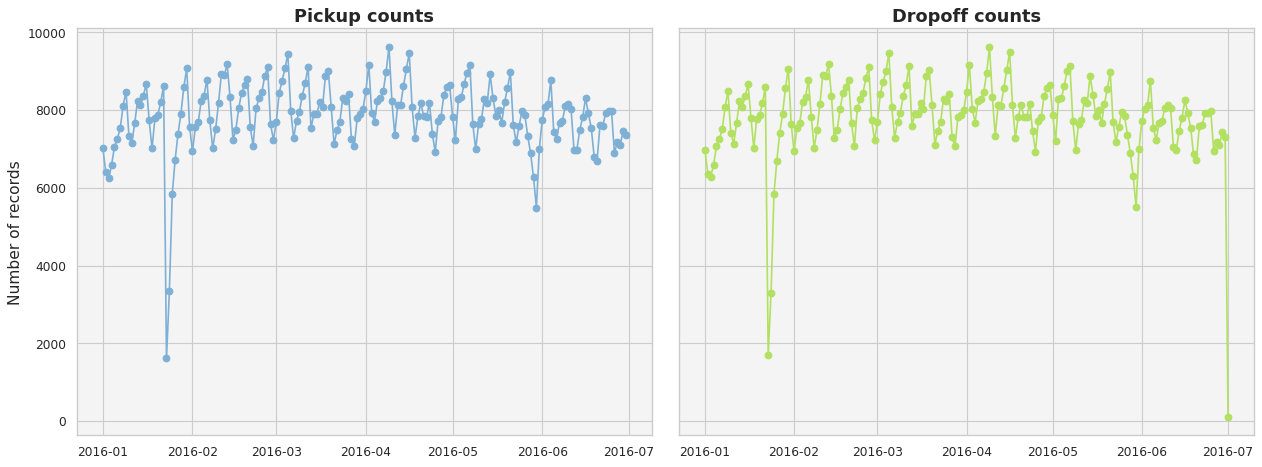

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True, dpi=80)
ax[0].plot(train.groupby('pickup_date').count()['id'], linestyle='-', marker='o', color='#7eb0d5')
ax[1].plot(train.groupby('dropoff_date').count()['id'], linestyle='-', marker='o', color='#b2e061')

ax[0].set_ylabel('Number of records', fontsize=14)
ax[0].set_title('Pickup counts', fontweight='bold', fontsize=16)

ax[1].set_title('Dropoff counts', fontweight='bold', fontsize=16)

fig.savefig(os.path.join(data_path, 'images', 'pickups_dropoffs.png'))
plt.tight_layout()
plt.show()

In [33]:
print(f'Date with minimum number of pickups - {train.groupby("pickup_date").count()["id"].idxmin()}')

Date with minimum number of pickups - 2016-01-23


* The number of pickups and dropoffs in the 2016-01-23 has decreased significantly, we should take a closer look at this data.
* The average number of pickups and dropoffs is about 8000.

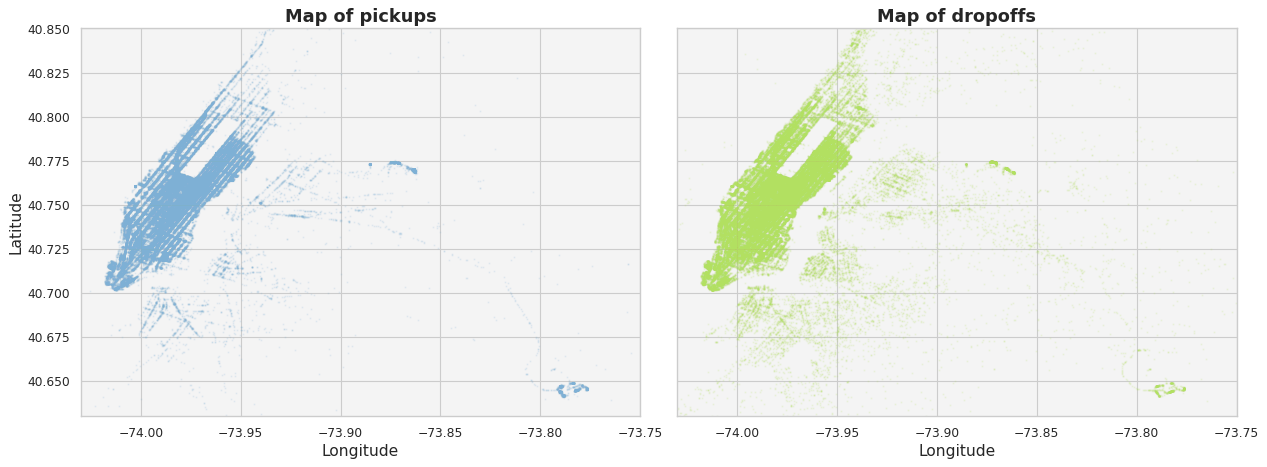

In [34]:
# Number of points
N = 100000

# City borders coordinates
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True, dpi=80)

ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N], color='#7eb0d5', s=1, alpha=0.1)
ax[1].scatter(train['dropoff_longitude'].values[:N], train['dropoff_latitude'].values[:N], color='#b2e061', s=1, alpha=0.1)

ax[0].set_ylabel('Latitude', fontsize=14)
ax[0].set_xlabel('Longitude', fontsize=14)
ax[1].set_xlabel('Longitude', fontsize=14)
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)

ax[0].set_title('Map of pickups', fontweight='bold', fontsize=16)
ax[1].set_title('Map of dropoffs', fontweight='bold', fontsize=16)

fig.savefig(os.path.join(data_path, 'images', 'map_pickups_dropoffs.png'))
plt.tight_layout()
plt.show()

From the map of pickups and dropoffs, we can see that most of the trips were made in Manhattan. The other two places with the most pickups and dropoffs are two airports: John F. Kennedy International Airport (JFK) and LaGuardia Airport (LGA).

### Passengers

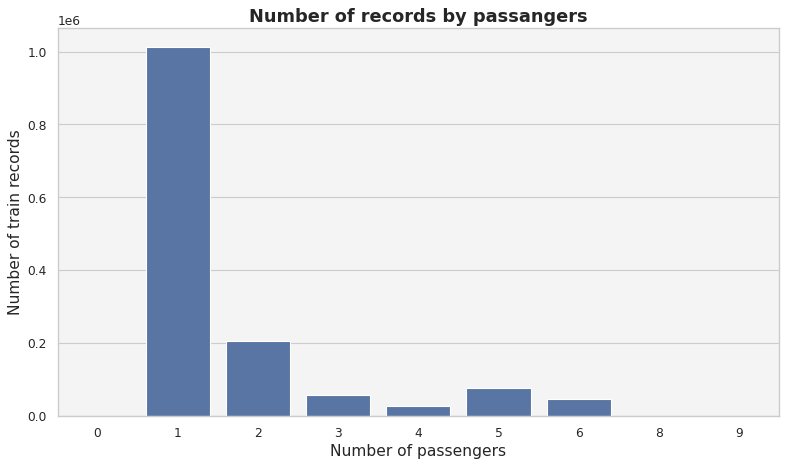

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=80)
sns.barplot(train['passenger_count'].value_counts(), ax=ax)

ax.set_xlabel('Number of passengers', fontsize=14)
ax.set_ylabel('Number of train records', fontsize=14)
ax.set_title('Number of records by passangers', fontweight='bold', fontsize=16)

fig.savefig(os.path.join(data_path, 'images', 'records_passangers.png'))
plt.tight_layout()
plt.show()

The [maximum number](https://portal.311.nyc.gov/article/?kanumber=KA-01245) of passengers allowed in a taxicab by law is 4 or 5. There is an exception that an additional passenger must be accepted if that passenger is under age 7 and is held on the lap of an adult passenger seated in the rear seat. If a passenger is unable to fit or ride in the back seat of the taxicab, they may occupy the front seat alongside the driver.

* There are some trips with 0 passengers.
* Some trips had 8 or 9 passengers, although the maximum number of passengers is 7 (5 in the back seat, 1 in the front seat + 1 child). These are clearly outliers and an indication of data inconsistency.
* Most trips had 1 or 2 passengers.

In [36]:
# Remove rows with 0, 8 or 9 passangers
train = train[(train['passenger_count'] > 0) & (train['passenger_count'] < 8)]

### Store flag

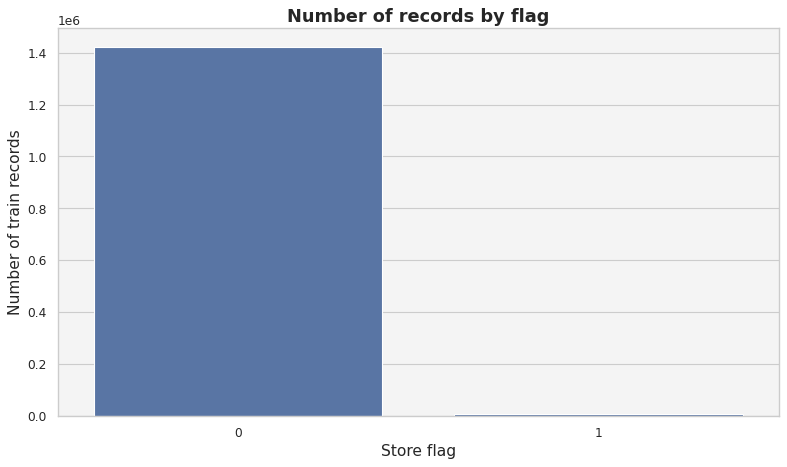

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=80)
sns.barplot(train['store_and_fwd_flag'].value_counts(), ax=ax)

ax.set_xlabel('Store flag', fontsize=14)
ax.set_ylabel('Number of train records', fontsize=14)
ax.set_title('Number of records by flag', fontweight='bold', fontsize=16)

fig.savefig(os.path.join(data_path, 'images', 'records_flag.png'))
plt.tight_layout()
plt.show()

Most of the orders are sent immediately to the vendor's server, but a small portion of them are held in the taxi's memory.

## Feature engineering

### Dates

In [38]:
# Extract dates from datetime of pickups
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_week'] = train['pickup_datetime'].dt.isocalendar().week
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_week'] = test['pickup_datetime'].dt.isocalendar().week
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

#### Pickup and dropoff

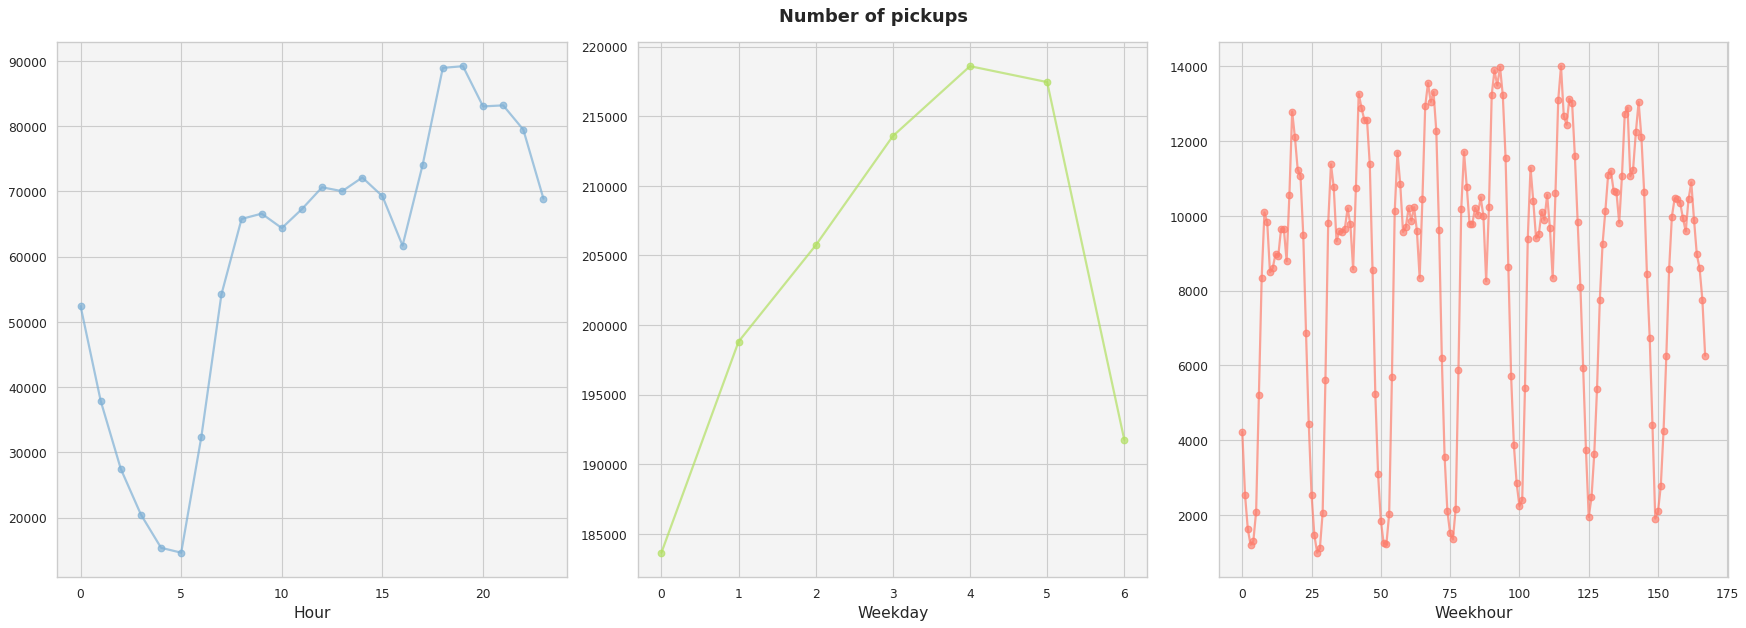

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(22, 8), dpi=80)

ax[0].plot(train.groupby('pickup_hour').size(), color='#7eb0d5', marker='o', linewidth=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').size(), color='#b2e061', marker='o', linewidth=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').size(), color='#fd7f6f', marker='o', linewidth=2, alpha=0.7)

ax[0].set_xlabel('Hour', fontsize=14)
ax[1].set_xlabel('Weekday', fontsize=14)
ax[2].set_xlabel('Weekhour', fontsize=14)

fig.suptitle('Number of pickups', fontweight='bold', fontsize=16)

fig.savefig(os.path.join(data_path, 'images', 'pickups.png'))
plt.tight_layout()
plt.show()

* From the graphs we can see that the busiest hours are around 5-7 PM. And most free hours is about 5 AM.
* Friday is the busiest day of the week.
* The number of trips is lowest at the beginning of the weekend, then it increases until Friday, then it goes down significantly during the weekend.

### Weather features

In [40]:
# Create temperature dates
temperature_df['datetime'] = pd.to_datetime(temperature_df['datetime'])
temperature_df['pickup_date'] = temperature_df['datetime'].dt.date
temperature_df['pickup_hour'] = temperature_df['datetime'].dt.hour
temperature_df = temperature_df.drop(columns=['datetime'])

In [41]:
# Create humidity dates
humidity_df['datetime'] = pd.to_datetime(humidity_df['datetime'])
humidity_df['pickup_date'] = humidity_df['datetime'].dt.date
humidity_df['pickup_hour'] = humidity_df['datetime'].dt.hour
humidity_df = humidity_df.drop(columns=['datetime'])

In [42]:
# Create pressure dates
pressure_df['datetime'] = pd.to_datetime(pressure_df['datetime'])
pressure_df['pickup_date'] = pressure_df['datetime'].dt.date
pressure_df['pickup_hour'] = pressure_df['datetime'].dt.hour
pressure_df = pressure_df.drop(columns=['datetime'])

In [43]:
# Create wind direction dates
wind_direction_df['datetime'] = pd.to_datetime(wind_direction_df['datetime'])
wind_direction_df['pickup_date'] = wind_direction_df['datetime'].dt.date
wind_direction_df['pickup_hour'] = wind_direction_df['datetime'].dt.hour
wind_direction_df = wind_direction_df.drop(columns=['datetime'])

In [44]:
# Create wind speed dates
wind_speed_df['datetime'] = pd.to_datetime(wind_speed_df['datetime'])
wind_speed_df['pickup_date'] = wind_speed_df['datetime'].dt.date
wind_speed_df['pickup_hour'] = wind_speed_df['datetime'].dt.hour
wind_speed_df = wind_speed_df.drop(columns=['datetime'])

In [45]:
# Merge temperature to the train and test
train = train.merge(temperature_df,
                    on=['pickup_date', 'pickup_hour'],
                    how='left')
print(f'Number of missing values - {train["temperature"].isna().sum()}')

test = test.merge(temperature_df,
                  on=['pickup_date', 'pickup_hour'],
                  how='left')
print(f'Number of missing values - {test["temperature"].isna().sum()}')

Number of missing values - 0
Number of missing values - 0


In [46]:
# Merge humidity to the train and test
train = train.merge(humidity_df,
                    on=['pickup_date', 'pickup_hour'],
                    how='left')
print(f'Number of missing values - {train["humidity"].isna().sum()}')

test = test.merge(humidity_df,
                  on=['pickup_date', 'pickup_hour'],
                  how='left')
print(f'Number of missing values - {test["humidity"].isna().sum()}')

Number of missing values - 0
Number of missing values - 0


In [47]:
# Merge pressure to the train and test
train = train.merge(pressure_df,
                    on=['pickup_date', 'pickup_hour'],
                    how='left')
print(f'Number of missing values - {train["pressure"].isna().sum()}')

test = test.merge(pressure_df,
                  on=['pickup_date', 'pickup_hour'],
                  how='left')
print(f'Number of missing values - {test["pressure"].isna().sum()}')

Number of missing values - 0
Number of missing values - 0


In [48]:
# Merge wind direction to the train and test
train = train.merge(wind_direction_df,
                    on=['pickup_date', 'pickup_hour'],
                    how='left')
print(f'Number of missing values - {train["wind_direction"].isna().sum()}')

test = test.merge(wind_direction_df,
                  on=['pickup_date', 'pickup_hour'],
                  how='left')
print(f'Number of missing values - {test["wind_direction"].isna().sum()}')

Number of missing values - 0
Number of missing values - 0


In [49]:
# Merge wind speed to the train and test
train = train.merge(wind_speed_df,
                    on=['pickup_date', 'pickup_hour'],
                    how='left')
print(f'Number of missing values - {train["wind_speed"].isna().sum()}')

test = test.merge(wind_speed_df,
                  on=['pickup_date', 'pickup_hour'],
                  how='left')
print(f'Number of missing values - {test["wind_speed"].isna().sum()}')

Number of missing values - 0
Number of missing values - 0


Now the train and test data contains information about the weather on the date of the trip.

### Special events and holidays




On 23 January 2016 there was a snowstorm in NYC. Therefore, there is a significant drop in pickups and dropoffs on that day. Using [information](https://www.weather.gov/okx/stormevents) about special weather events, we create a new feature called extreme_weather, which tells us if there were any extreme weather conditions on that date.

In [50]:
weather_events = ['2016-01-10', '2016-01-13', '2016-01-17', '2016-01-23',
                  '2016-02-05', '2016-02-08', '2016-02-15', '2016-02-16',
                  '2016-02-24', '2016-02-25',
                  '2016-03-14', '2016-03-15', '2016-03-21', '2016-03-28',
                  '2016-03-29',
                  '2016-04-03', '2016-04-04',
                  '2016-05-30',
                  '2016-06-28']
weather_events = pd.Series(pd.to_datetime(weather_events, format='%Y-%m-%d')).dt.date

In [51]:
train['extreme_weather'] = train['pickup_date'].isin(weather_events).map({True: 1, False: 0})
test['extreme_weather'] = test['pickup_date'].isin(weather_events).map({True: 1, False: 0})

We can also take into account holidays, we will create another feature that will tell if there was a holiday or not.

In [52]:
holidays = ['2016-01-01', '2016-01-18',
            '2016-02-12', '2016-02-15',
            '2016-05-08', '2016-05-30',
            '2016-06-19']
holidays = pd.Series(pd.to_datetime(holidays, format='%Y-%m-%d')).dt.date

In [53]:
train['is_holiday'] = train['pickup_date'].isin(holidays).map({True: 1, False: 0})
test['is_holiday'] = test['pickup_date'].isin(holidays).map({True: 1, False: 0})

### Distance

In [54]:
def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance (Haversine distance) between two points on the earth.

    Parameters:
        lon1 (float): longitude of the 1st point.
        lat1 (float): latitude of the 1st point.
        lon2 (float): longitude of the 2nd point.
        lat2 (float): latitude of the 2nd point.

    Returns:
        float: The Haversine distance between the two points in kilometers.
    """
    R = 6371.0

    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Compute the differences between latitudes and longitudes
    d_lat = lat2 - lat1
    d_lon = lon2 - lon1

    # Haversine formula
    a = np.sin(d_lat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(d_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c

    return distance

In [55]:
# Calculate the haversine distance for each trip
train['distance_km'] = haversine_distance(train['pickup_longitude'].values,
                                          train['pickup_latitude'].values,
                                          train['dropoff_longitude'].values,
                                          train['dropoff_latitude'].values)

test['distance_km'] = haversine_distance(test['pickup_longitude'].values,
                                         test['pickup_latitude'].values,
                                         test['dropoff_longitude'].values,
                                         test['dropoff_latitude'].values)

In [56]:
def manhattan_distance(lon1, lat1, lon2, lat2):
    """
    Calculate the Manhattan distance between two points on the earth.

    Parameters:
        lon1 (float): longitude of the 1st point.
        lat1 (float): latitude of the 1st point.
        lon2 (float): longitude of the 2nd point.
        lat2 (float): latitude of the 2nd point.

    Returns:
        float: The Manhattan distance between the two points.
    """
    R = 6371.0

    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Compute the differences in coordinates
    d_lat = lat2 - lat1
    d_lon = lon2 - lon1

    # Calculate the Manhattan distance: sum of latitudinal and longitudinal distances
    a_lat = R * np.abs(d_lat)
    a_lon = R * np.abs(d_lon) * np.cos((lat1 + lat2) / 2)

    # Return the Manhattan distance
    return a_lat + a_lon

In [57]:
# Calculate the Manhattan distance for each trip
train['manhattan_distance_km'] = manhattan_distance(train['pickup_longitude'].values,
                                                    train['pickup_latitude'].values,
                                                    train['dropoff_longitude'].values,
                                                    train['dropoff_latitude'].values)

test['manhattan_distance_km'] = manhattan_distance(test['pickup_longitude'].values,
                                                   test['pickup_latitude'].values,
                                                   test['dropoff_longitude'].values,
                                                   test['dropoff_latitude'].values)

In [58]:
def calculate_bearing(lon1, lat1, lon2, lat2):
    """
    Calculate the bearing angle between two points on the earth.

    Parameters:
        lon1 (float): longitude of the 1st point.
        lat1 (float): latitude of the 1st point.
        lon2 (float): longitude of the 2nd point.
        lat2 (float): latitude of the 2nd point.

    Returns:
        float: Bearing angle in degrees.
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Calculate the differences in longitude
    d_lon = lon2 - lon1

    # Calculate the bearing using the formula
    x = np.sin(d_lon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(d_lon)

    # Calculate the initial bearing angle in radians
    bearing_rad = np.arctan2(x, y)

    # Convert the bearing angle from radians to degrees
    bearing_deg = np.degrees(bearing_rad)

    # Normalize the bearing to 0-360 degrees
    bearing_deg = (bearing_deg + 360) % 360

    return bearing_deg

In [59]:
# Calculate the bearing angle for each trip
train['bearing_angle'] = calculate_bearing(train['pickup_longitude'].values,
                                           train['pickup_latitude'].values,
                                           train['dropoff_longitude'].values,
                                           train['dropoff_latitude'].values)

test['bearing_angle'] = calculate_bearing(test['pickup_longitude'].values,
                                          test['pickup_latitude'].values,
                                          test['dropoff_longitude'].values,
                                          test['dropoff_latitude'].values)

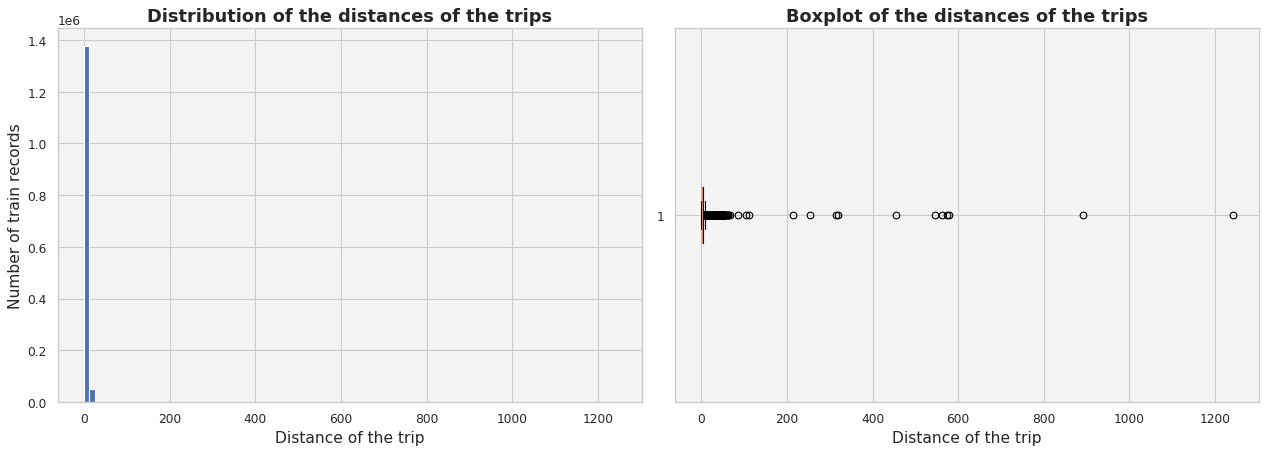

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=80)

ax[0].hist(train['distance_km'].values, bins=100)
ax[1].boxplot(train['distance_km'].values, vert=False)

ax[0].set_xlabel('Distance of the trip', fontsize=14)
ax[0].set_ylabel('Number of train records', fontsize=14)
ax[0].set_title('Distribution of the distances of the trips', fontweight='bold', fontsize=16)

ax[1].set_xlabel('Distance of the trip', fontsize=14)
ax[1].set_title('Boxplot of the distances of the trips', fontweight='bold', fontsize=16)

fig.savefig(os.path.join(data_path, 'images', 'distances.png'))
plt.tight_layout()
plt.show()

In [61]:
trip_duration_intervals = (train['distance_km']
    .groupby(
        pd.cut(train['distance_km'],
               np.arange(1, max(train['distance_km']), 10)),
        observed=False)
    .count()
    .sort_values(ascending=False))
trip_duration_intervals.head()

,distance_km
distance_km,
"(1.0, 11.0]",1135675
"(11.0, 21.0]",53964
"(21.0, 31.0]",8532
"(31.0, 41.0]",224
"(41.0, 51.0]",44


In [62]:
print(f'Number of trips with 0 km distance - {train["distance_km"][train["distance_km"] == 0].count()}')

Number of trips with 0 km distance - 4061


* Most trips are less than 10 km.
* Some trips have a distance of 0 or about 0 km.
* Some trips have distances of more than 100 km.

In [63]:
print(f'1st percentile - {train["distance_km"].quantile(0.01)}')
print(f'99nd percentile - {train["distance_km"].quantile(0.99)}')

1st percentile - 0.3128232893754701
99nd percentile - 20.35128297492506


In [64]:
print(f'1st percentile - {train["manhattan_distance_km"].quantile(0.01)}')
print(f'99nd percentile - {train["manhattan_distance_km"].quantile(0.99)}')

1st percentile - 0.39083644571643134
99nd percentile - 28.147535036931824


The longest distance between NYC's borders, from northeast to southwest, is about 35 miles (~56 km). So we will use this value for the upper limit of the distance.

In [65]:
# Calculate the 1st percentile (1%)
lower_bound = train['distance_km'].quantile(0.01)

# Remove outliers
train = train[(train['distance_km'] >= lower_bound) & (train['distance_km'] <= 56)]
train = train[(train['manhattan_distance_km'] >= lower_bound) & (train['manhattan_distance_km'] <= 56)]

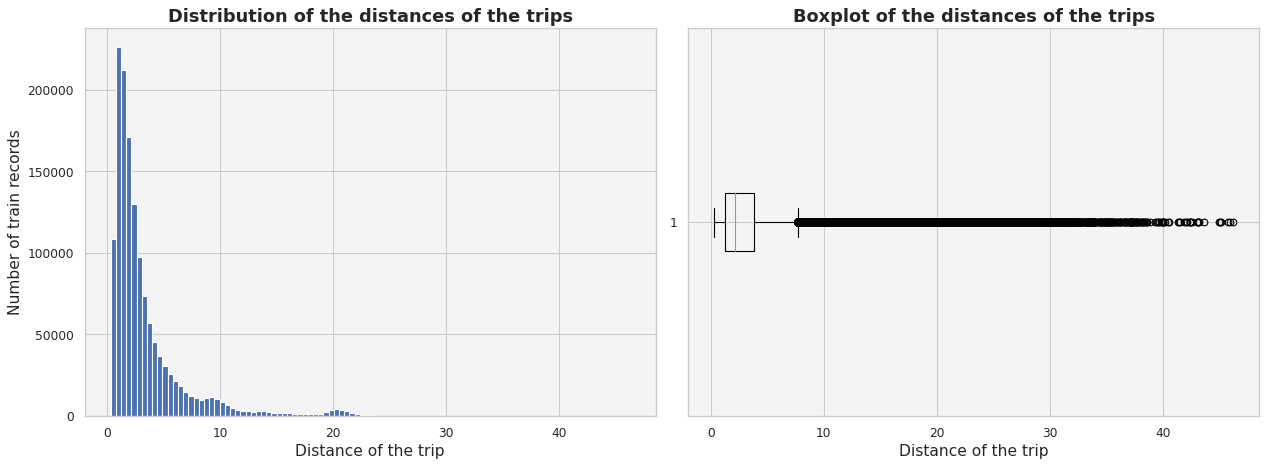

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=80)

ax[0].hist(train['distance_km'].values, bins=100)
ax[1].boxplot(train['distance_km'].values, vert=False)

ax[0].set_xlabel('Distance of the trip', fontsize=14)
ax[0].set_ylabel('Number of train records', fontsize=14)
ax[0].set_title('Distribution of the distances of the trips', fontweight='bold', fontsize=16)

ax[1].set_xlabel('Distance of the trip', fontsize=14)
ax[1].set_title('Boxplot of the distances of the trips', fontweight='bold', fontsize=16)

fig.savefig(os.path.join(data_path, 'images', 'distances2.png'))
plt.tight_layout()
plt.show()

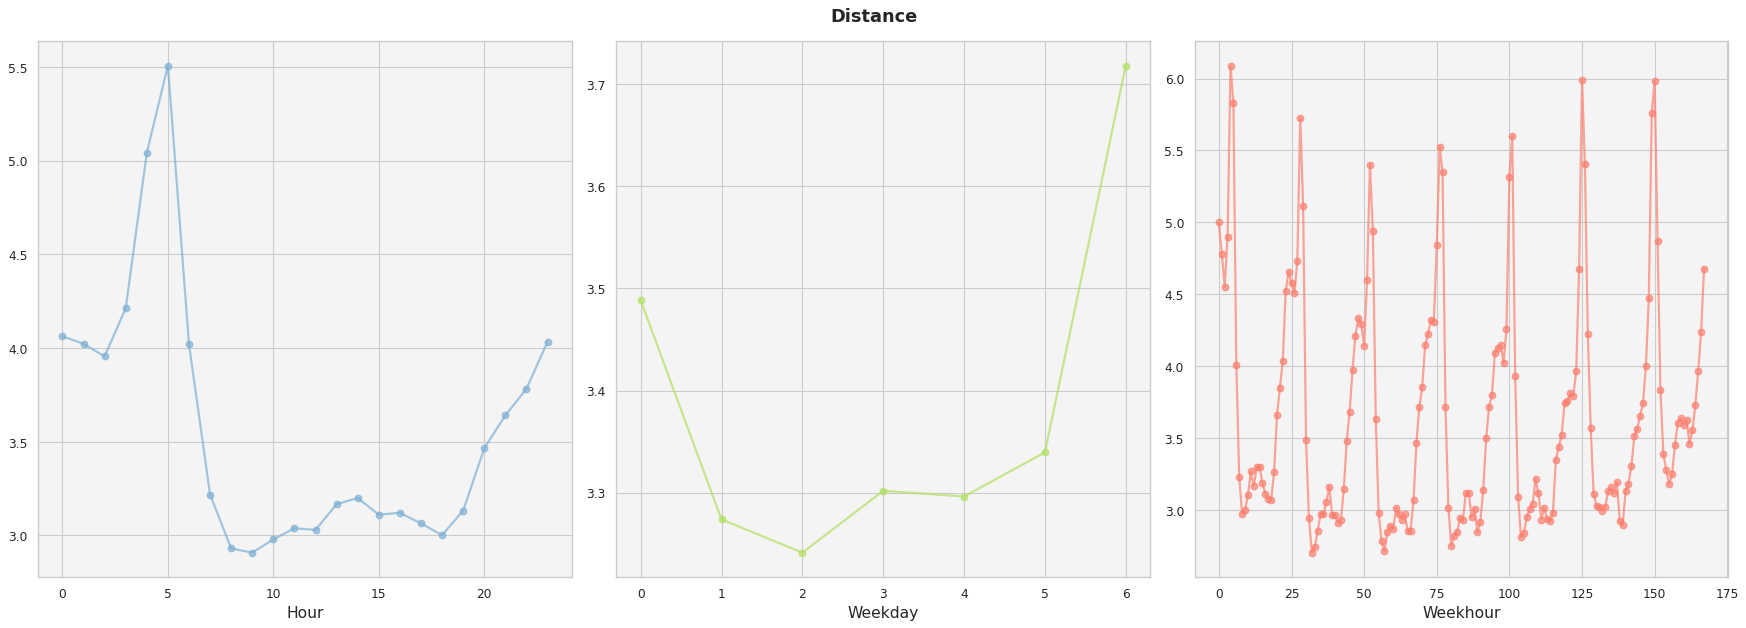

In [67]:
fig, ax = plt.subplots(1, 3, figsize=(22, 8), dpi=80)

ax[0].plot(train[['distance_km', 'pickup_hour']].groupby('pickup_hour').mean(), color='#7eb0d5', marker='o', linewidth=2, alpha=0.7)
ax[1].plot(train[['distance_km', 'pickup_weekday']].groupby('pickup_weekday').mean(), color='#b2e061', marker='o', linewidth=2, alpha=0.7)
ax[2].plot(train[['distance_km', 'pickup_week_hour']].groupby('pickup_week_hour').mean(), color='#fd7f6f', marker='o', linewidth=2, alpha=0.7)

ax[0].set_xlabel('Hour', fontsize=14)
ax[1].set_xlabel('Weekday', fontsize=14)
ax[2].set_xlabel('Weekhour', fontsize=14)

fig.suptitle('Distance', fontweight='bold', fontsize=16)

fig.savefig(os.path.join(data_path, 'images', 'distances3.png'))
plt.tight_layout()
plt.show()

* The trip distance, on the contrary, is greatest at 5 AM and smallest during rush hours.
* Distance is greatest on weekends.

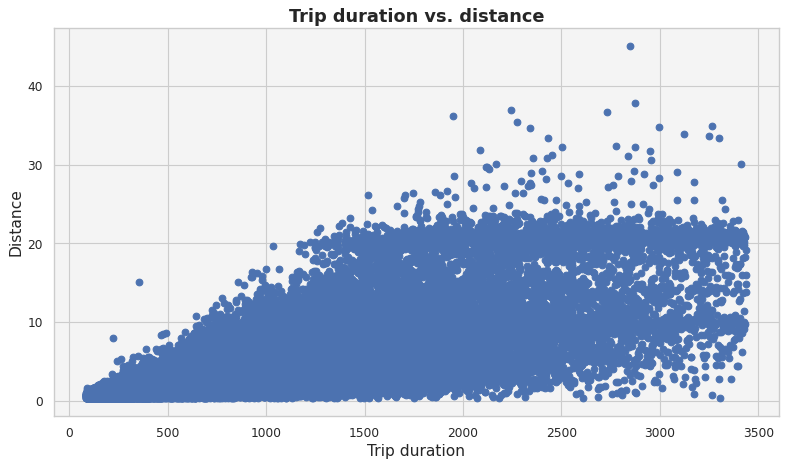

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=80)

ax.scatter(train['trip_duration'][:N], train['distance_km'][:N])

ax.set_xlabel('Trip duration', fontsize=14)
ax.set_ylabel('Distance', fontsize=14)
ax.set_title('Trip duration vs. distance', fontweight='bold', fontsize=16)

fig.savefig(os.path.join(data_path, 'images', 'duration_distance.png'))
plt.tight_layout()
plt.show()

There is a linear correlation between trip duration and distance.

### Speed

In [69]:
# Calculate average speed in km/h
train.loc[:, 'avg_speed_h'] = train['distance_km'] / (train['trip_duration'] / 3600)
train.loc[:, 'avg_speed_m'] = train['manhattan_distance_km'] / (train['trip_duration'] / 3600)

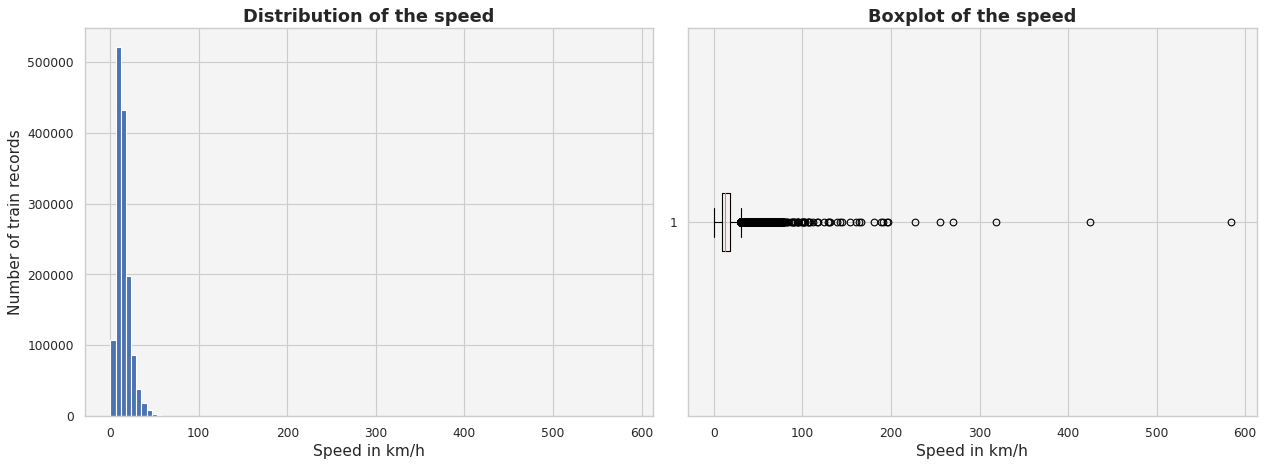

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=80)

ax[0].hist(train['avg_speed_h'].values, bins=100)
ax[1].boxplot(train['avg_speed_h'].values, vert=False)

ax[0].set_xlabel('Speed in km/h', fontsize=14)
ax[0].set_ylabel('Number of train records', fontsize=14)
ax[0].set_title('Distribution of the speed', fontweight='bold', fontsize=16)

ax[1].set_xlabel('Speed in km/h', fontsize=14)
ax[1].set_title('Boxplot of the speed', fontweight='bold', fontsize=16)

fig.savefig(os.path.join(data_path, 'images', 'speed.png'))
plt.tight_layout()
plt.show()

* The NYS statewide maximum speed limit is 55 mph (~88.5 km/h).
* The NYC citywide maximum speed limit is 25 mph (~40 km/h) unless otherwise posted.

In [71]:
print(f'1st percentile - {train["avg_speed_h"].quantile(0.01)}')
print(f'99nd percentile - {train["avg_speed_h"].quantile(0.99)}')

1st percentile - 3.507508237275137
99nd percentile - 40.450973914735904


In [72]:
print(f'1st percentile - {train["avg_speed_m"].quantile(0.01)}')
print(f'99nd percentile - {train["avg_speed_m"].quantile(0.99)}')

1st percentile - 4.3417968890762655
99nd percentile - 54.514242167765694


The 99th percentile corresponds to the city limit of NYC. Most of the pickups and drop-offs are within the city borders, so we will use this value as the upper bound of the speed.

In [73]:
# Calculate the 1st percentile and 99th percentile
lower_bound = train['avg_speed_h'].quantile(0.01)
upper_bound = train['avg_speed_h'].quantile(0.99)

# Remove outliers
train = train[(train['avg_speed_h'] >= lower_bound) & (train['avg_speed_h'] <= upper_bound)]
train = train[(train['avg_speed_m'] >= lower_bound) & (train['avg_speed_m'] <= upper_bound)]

#### Average speed by dates

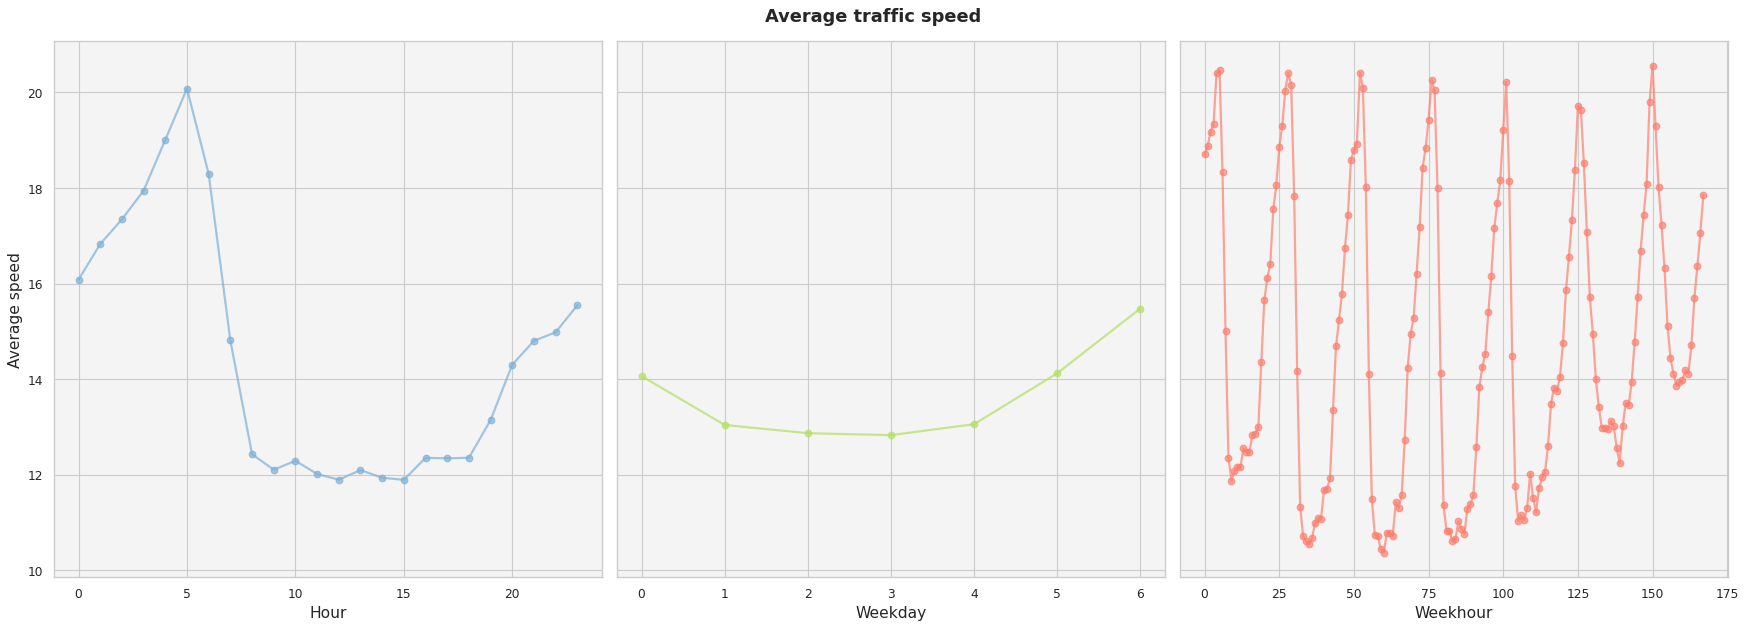

In [74]:
fig, ax = plt.subplots(1, 3, figsize=(22, 8), dpi=80, sharey=True)

ax[0].plot(train[['pickup_hour', 'avg_speed_h']].groupby('pickup_hour').mean()['avg_speed_h'], color='#7eb0d5', marker='o', linewidth=2, alpha=0.7)
ax[1].plot(train[['pickup_weekday', 'avg_speed_h']].groupby('pickup_weekday').mean()['avg_speed_h'], color='#b2e061', marker='o', linewidth=2, alpha=0.7)
ax[2].plot(train[['pickup_week_hour', 'avg_speed_h']].groupby('pickup_week_hour').mean()['avg_speed_h'], color='#fd7f6f', marker='o', linewidth=2, alpha=0.7)

ax[0].set_xlabel('Hour', fontsize=14)
ax[1].set_xlabel('Weekday', fontsize=14)
ax[2].set_xlabel('Weekhour', fontsize=14)

ax[0].set_ylabel('Average speed', fontsize=14)

fig.suptitle('Average traffic speed', fontweight='bold', fontsize=16)

fig.savefig(os.path.join(data_path, 'images', 'speed2.png'))
plt.tight_layout()
plt.show()

As with travel distance, average traffic speed is highest at 5 a.m. and lowest during rush hour.

#### Average speed by regions

In [75]:
# Create latitude and longitude bins
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_lon_bin'] = np.round(train['pickup_longitude'], 3)

# Calculate the average speed and number of trips
cols = ['pickup_lat_bin', 'pickup_lon_bin']
coord_speed = train.groupby(cols)['avg_speed_h'].mean().reset_index()
coord_count = train.groupby(cols)['id'].count().reset_index()

# Merge speed, count tables and filter out regions with fewer than 100 trips
coord_stats = pd.merge(coord_speed, coord_count, on=cols)
coord_stats = coord_stats[coord_stats['id'] > 100]

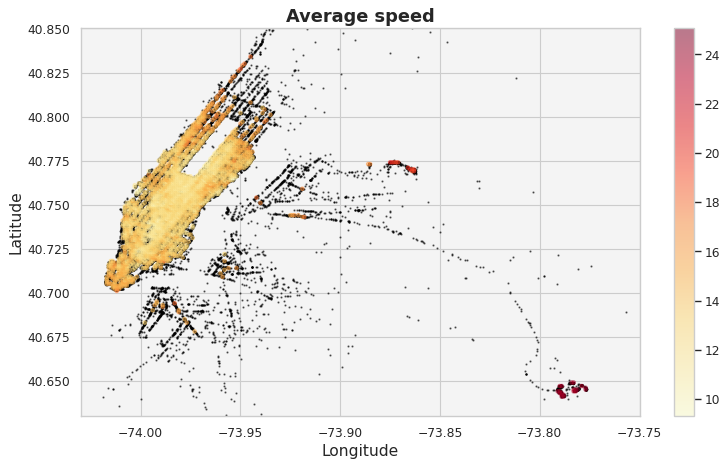

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=80)

# Scatter plot of pickup locations (black)
ax.scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
           color='black', s=1, alpha=0.5)

# Scatter plot of average speed by region
sp = ax.scatter(coord_stats['pickup_lon_bin'].values, coord_stats['pickup_lat_bin'].values,
                c=coord_stats['avg_speed_h'].values,
                vmin=coord_stats['avg_speed_h'].values.min(),
                vmax=coord_stats['avg_speed_h'].values.max(),
                cmap='YlOrRd', s=10, alpha=0.5)

ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)

ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

ax.set_title('Average speed', fontweight='bold', fontsize=16)

plt.colorbar(sp)
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(data_path, 'images', 'avg_speed.png'))

#### Pickup clustering

In [77]:
# Coordinates of pickups and dropoffs
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

In [78]:
# Randomly permute the indices and select the first 500K
sample_ind = np.random.permutation(len(coords))[:500000]

# Perform MiniBatch K-Means clustering
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000, n_init='auto').fit(coords[sample_ind])

In [79]:
# Create new cluster feature
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']].values)
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']].values)

test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']].values)
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']].values)

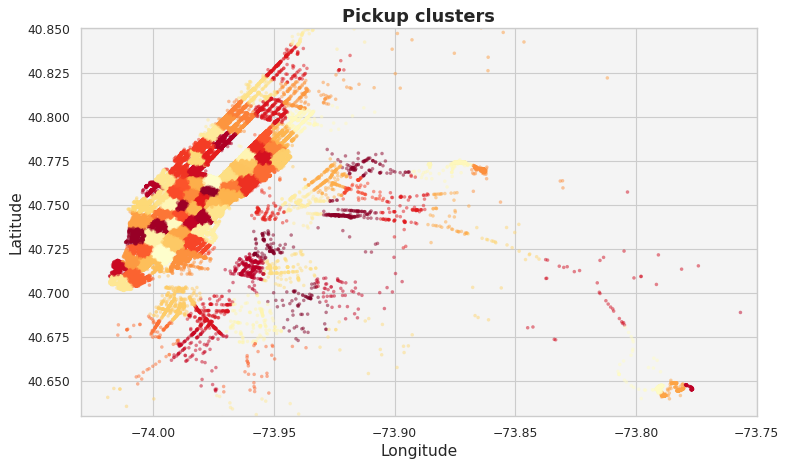

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=80)

ax.scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
           c=train['pickup_cluster'][:N].values,
           linewidth=0, s=10, alpha=0.5, cmap='YlOrRd')

ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)

ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

ax.set_title('Pickup clusters', fontweight='bold', fontsize=16)

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(data_path, 'images', 'pickup_clusters.png'))

### PCA

We use PCA to transform longitude and latitude coordinates. In this case it is not about dimension reduction since we transform 2D -> 2D. The rotation could help for decision tree splits.

In [81]:
pca = PCA().fit(coords)

train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']].values)[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']].values)[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']].values)[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']].values)[:, 1]

test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']].values)[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']].values)[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']].values)[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']].values)[:, 1]

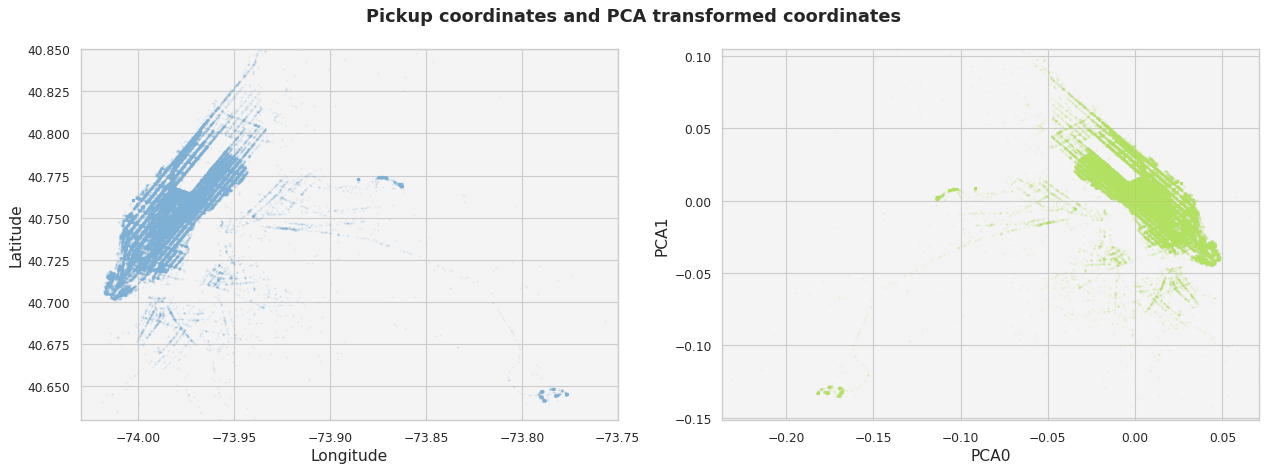

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=80)

ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N], color='#7eb0d5', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N], color='#b2e061', s=1, alpha=0.1)

ax[0].set_xlabel('Longitude', fontsize=14)
ax[0].set_ylabel('Latitude', fontsize=14)

ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)

ax[1].set_xlabel('PCA0', fontsize=14)
ax[1].set_ylabel('PCA1', fontsize=14)

pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())

fig.suptitle('Pickup coordinates and PCA transformed coordinates', fontweight='bold', fontsize=16)

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(data_path, 'images', 'coordinates.png'))

In [83]:
# Calculate Manhattan distance using PCAed coordinates
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

### New coordinates

In [84]:
# Find center coordinate between pickup and dropoff point
train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2

test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

In [85]:
# Create latitude and longitude bins
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_lon_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_lon_bin'] = np.round(train['center_longitude'], 2)

test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_lon_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_lon_bin'] = np.round(test['center_longitude'], 2)

### Temporal and geospatial aggregation

In [86]:
for group_col in ['pickup_hour', 'pickup_date', 'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    group = train.groupby(group_col)[['avg_speed_h', 'avg_speed_m', 'log_trip_duration']].mean()
    group.columns = [f'{col}_group_{group_col}' for col in group.columns]

    train = pd.merge(train, group, how='left', left_on=group_col, right_index=True)
    test = pd.merge(test, group, how='left', left_on=group_col, right_index=True)

* Time-related groupings (pickup_hour, pickup_date, pickup_week_hour) inroduce features which add time-based dynamics into predictions, which help account for traffic variability throughout the hour, date, week hour.
* Location-based groupings (pickup_cluster, dropoff_cluster) inroduce features which allow the model to capture regional traffic patterns, identifying how different areas contribute to travel speed and trip duration.

In [87]:
for group_cols in [['center_lat_bin', 'center_lon_bin'],
                   ['pickup_hour', 'center_lat_bin', 'center_lon_bin'],
                   ['pickup_hour', 'pickup_cluster'],
                   ['pickup_hour', 'dropoff_cluster'],
                   ['pickup_cluster', 'dropoff_cluster']]:
    # Calculate the average speed and number of trips
    coord_speed = train.groupby(group_cols)['avg_speed_h'].mean().reset_index()
    coord_count = train.groupby(group_cols)['id'].count().reset_index()

    # Merge speed, count tables and filter out regions with fewer than 100 trips
    coord_stats = pd.merge(coord_speed, coord_count, on=group_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = group_cols + [f'avg_speed_h_{"_".join(group_cols)}', f'cnt_{"_".join(group_cols)}']

    train = pd.merge(train, coord_stats, how='left', on=group_cols)
    test = pd.merge(test, coord_stats, how='left', on=group_cols)

* These features provide data on how often certain regions, clusters, or routes are used and what average speed is typically observed. This allows the model to better understand how local patterns affect trip duration.
* By adding time (hour) and geographic bins (or clusters), the model can handle variability in traffic conditions, route preferences, and travel patterns.

In [88]:
# Time interval frequency
group_freq = '60min'

# Concatenate train and test
df_combined = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]

# Group by time interval frequency
train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

In [89]:
# Set datetime as index, select id, sort indices
df_counts = df_combined.set_index('pickup_datetime')[['id']].sort_index()

# Apply rolling operation with 60 min frequency, count trips
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']

# Merge to the train and test
train = train.merge(df_counts, on='id', how='left')
test = test.merge(df_counts, on='id', how='left')

In [90]:
# Count number of dropoffs in cluster by time interval
dropoff_counts = (
    df_combined.groupby([pd.Grouper(key='pickup_datetime', freq=group_freq),
                         'dropoff_cluster'])
               .agg({'id': 'count'})
               .reset_index())

In [91]:
# 4-hour rolling average of trip counts for each cluster
dropoff_counts['dropoff_cluster_count'] = (
    dropoff_counts.set_index('pickup_datetime')
                  .groupby('dropoff_cluster')['id']
                  .rolling('240min').mean()
                  .reset_index(drop=True))

In [92]:
# Shift by -120 minutes
dropoff_counts['pickup_datetime_group'] = dropoff_counts['pickup_datetime'] - pd.Timedelta(minutes=120)

In [93]:
# Merge new features into train and test
train = train.merge(
    dropoff_counts[['pickup_datetime_group', 'dropoff_cluster', 'dropoff_cluster_count']],
    on=['pickup_datetime_group', 'dropoff_cluster'], how='left')

train['dropoff_cluster_count'] = train['dropoff_cluster_count'].fillna(0)

test = test.merge(
    dropoff_counts[['pickup_datetime_group', 'dropoff_cluster', 'dropoff_cluster_count']],
    on=['pickup_datetime_group', 'dropoff_cluster'], how='left')
test['dropoff_cluster_count'] = test['dropoff_cluster_count'].fillna(0)

## Model

In [94]:
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime',
                           'trip_duration', 'check_trip_duration',
                           'pickup_date', 'dropoff_date', 'avg_speed_h', 'avg_speed_m',
                           'pickup_lat_bin', 'pickup_lon_bin',
                           'center_lat_bin', 'center_lon_bin',
                           'pickup_datetime_group']

feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print(f'Number of features - {len(feature_names)}')

Number of features - 58


In [95]:
y = np.log(train['trip_duration'].values + 1)

In [96]:
X_train, X_val, y_train, y_val = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=42)

In [97]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

### Parameters tuning

In [98]:
# Create list of possible parameters
params_list = []

for mcw in [10, 20, 50, 75, 100]:
    for cs in [0.3, 0.4, 0.5, 0.7]:
        for md in [3, 4, 5, 6, 8, 10, 12, 15]:
            for ss in [0.5, 0.6, 0.7, 0.8, 0.9]:
                for rlambda in [0.5, 1, 1.5,  2, 3]:
                    for lr in [0.05, 0.1, 0.15]:
                        params_list.append({
                            'min_child_weight': mcw,
                            'colsample_bytree': cs,
                            'max_depth': md,
                            'subsample': ss,
                            'reg_lambda': rlambda,
                            'learning_rate' : lr,
                            'nthread': -1, 'booster' : 'gbtree',
                            'eval_metric': 'rmse'})

In [99]:
best_model_count = 0
best_score = 1
max_stopping_rounds = 20

while best_model_count < max_stopping_rounds:
    # Randomly select parameters from the params_list
    params = np.random.choice(params_list)
    print(f'Current parameters: {params}')

    # Train the model
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=10,
        evals=watchlist,
        early_stopping_rounds=50,
        maximize=False,
        verbose_eval=100
    )

    # Log the current model's score
    current_score = model.best_score
    print(f'Model RMSLE: {current_score:.5f}')

    # If current model performs better, update the best score
    if current_score < best_score:
        best_score = current_score
        best_model_count = 0
    else:
        best_model_count += 1

    # Stop if there has been no improvement for 5 iterations
    if best_model_count == max_stopping_rounds:
        print('No improvement after 5 iterations. Stopping...')
        break

Current parameters: {'min_child_weight': 75, 'colsample_bytree': 0.4, 'max_depth': 3, 'subsample': 0.6, 'reg_lambda': 3, 'learning_rate': 0.05, 'nthread': -1, 'booster': 'gbtree', 'eval_metric': 'rmse'}
[0]	train-rmse:0.65810	valid-rmse:0.65875
[9]	train-rmse:0.51912	valid-rmse:0.51990
Model RMSLE: 0.51990
Current parameters: {'min_child_weight': 50, 'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.9, 'reg_lambda': 1, 'learning_rate': 0.1, 'nthread': -1, 'booster': 'gbtree', 'eval_metric': 'rmse'}
[0]	train-rmse:0.62966	valid-rmse:0.63037
[9]	train-rmse:0.38299	valid-rmse:0.38385
Model RMSLE: 0.38385
Current parameters: {'min_child_weight': 100, 'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.5, 'reg_lambda': 1.5, 'learning_rate': 0.1, 'nthread': -1, 'booster': 'gbtree', 'eval_metric': 'rmse'}
[0]	train-rmse:0.63305	valid-rmse:0.63372
[9]	train-rmse:0.40152	valid-rmse:0.40228
Model RMSLE: 0.40228
Current parameters: {'min_child_weight': 75, 'colsample_bytree': 0.5, 'max_

### Final model

In [109]:
# Best parameters
xgb_params = {'min_child_weight': 10, 'colsample_bytree': 0.7, 'max_depth': 6,
              'subsample': 0.6, 'reg_lambda': 3, 'learning_rate': 0.15,
              'nthread': -1, 'booster': 'gbtree', 'eval_metric': 'rmse'}

# Train model
model = xgb.train(xgb_params, dtrain, num_boost_round=60, evals=watchlist,
                  early_stopping_rounds=50, maximize=False, verbose_eval=10)

[0]	train-rmse:0.60465	valid-rmse:0.60538
[10]	train-rmse:0.32579	valid-rmse:0.32654
[20]	train-rmse:0.29521	valid-rmse:0.29600
[30]	train-rmse:0.28653	valid-rmse:0.28751
[40]	train-rmse:0.28246	valid-rmse:0.28366
[50]	train-rmse:0.27995	valid-rmse:0.28137
[59]	train-rmse:0.27812	valid-rmse:0.27969


In [110]:
y_test = model.predict(dtest)
y_predictions = model.predict(dvalid)

test['trip_duration'] = np.exp(y_test) - 1

print(f'Valid prediction mean: {y_predictions.mean():.3f}')
print(f'Test prediction mean: {y_test.mean():.3f}')

Valid prediction mean: 6.466
Test prediction mean: 6.473


In [111]:
# Save predicted values
predictions_path = os.path.join(data_path, 'predictions.csv')

test[['id', 'trip_duration']].to_csv(predictions_path, index=False)

In [112]:
# Retrieve feature importance
feature_importance_dict = model.get_fscore()

# Generate indices
fs = [f'f{i}' for i in range(len(feature_names))]

# DataFrame with importance values
f1 = pd.DataFrame({'f':          list(feature_importance_dict.keys()),
                   'importance': list(feature_importance_dict.values())})

# DataFrame with feature names
f2 = pd.DataFrame({'f':            fs,
                   'feature_name': feature_names})

# Merge two DataFrames, fill null values
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)

feature_importance = feature_importance.sort_values(by='importance', ascending=False)

In [113]:
feature_importance

,f,importance,feature_name
21,f21,469.0,bearing_angle
19,f19,256.0,distance_km
54,f54,234.0,avg_speed_h_pickup_cluster_dropoff_cluster
52,f52,145.0,avg_speed_h_pickup_hour_dropoff_cluster
37,f37,142.0,avg_speed_h_group_pickup_week_hour
20,f20,132.0,manhattan_distance_km
48,f48,117.0,avg_speed_h_pickup_hour_center_lat_bin_center_...
56,f56,117.0,count_60min
36,f36,113.0,log_trip_duration_group_pickup_date
50,f50,94.0,avg_speed_h_pickup_hour_pickup_cluster


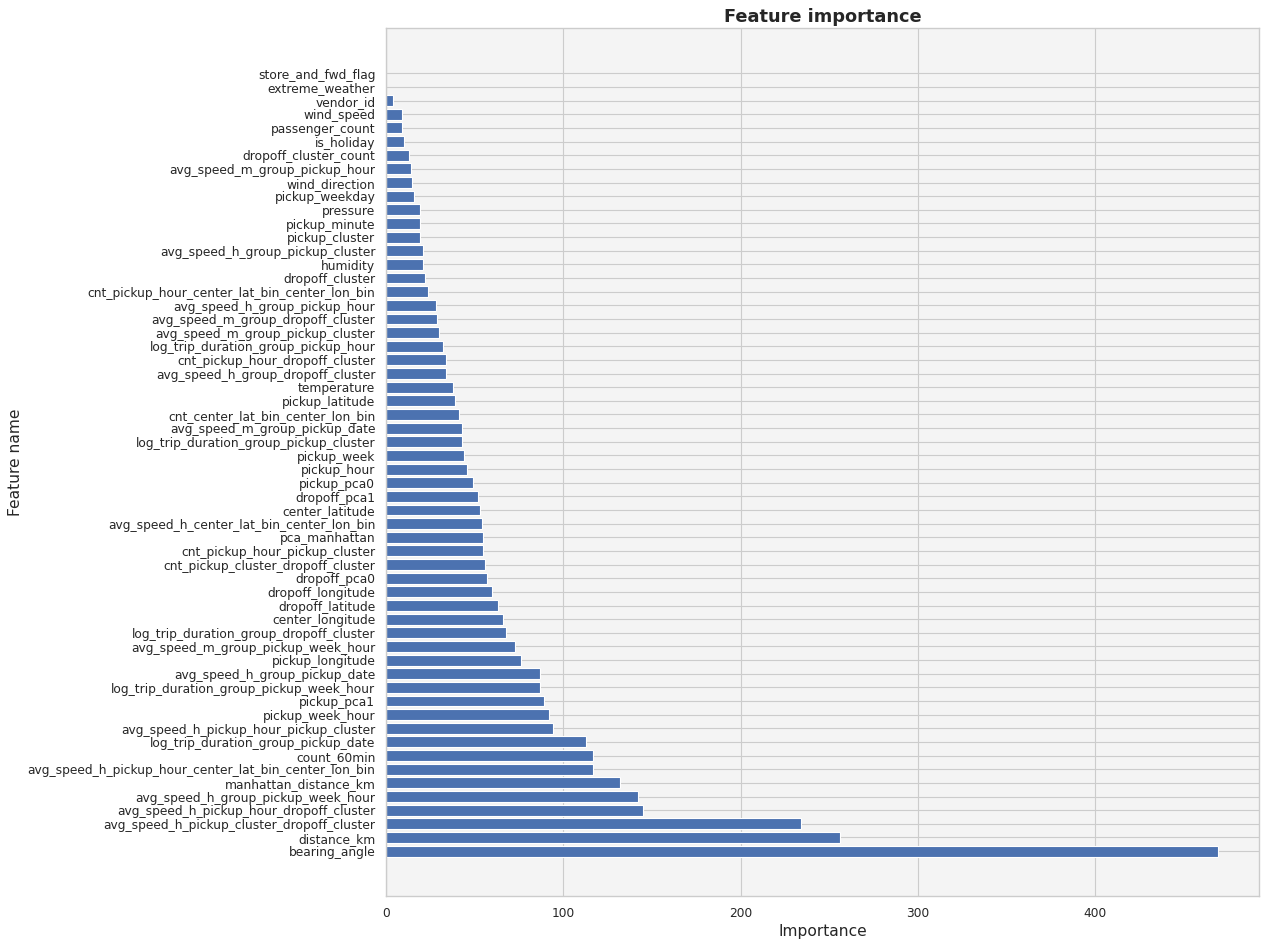

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=80)

ax.barh(y=feature_importance['feature_name'].values,
        width=feature_importance['importance'].values)

ax.set_xlabel('Importance', fontsize=14)
ax.set_ylabel('Feature name', fontsize=14)
ax.set_title('Feature importance', fontweight='bold', fontsize=16)

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(data_path, 'images', 'feature_importance.png'))

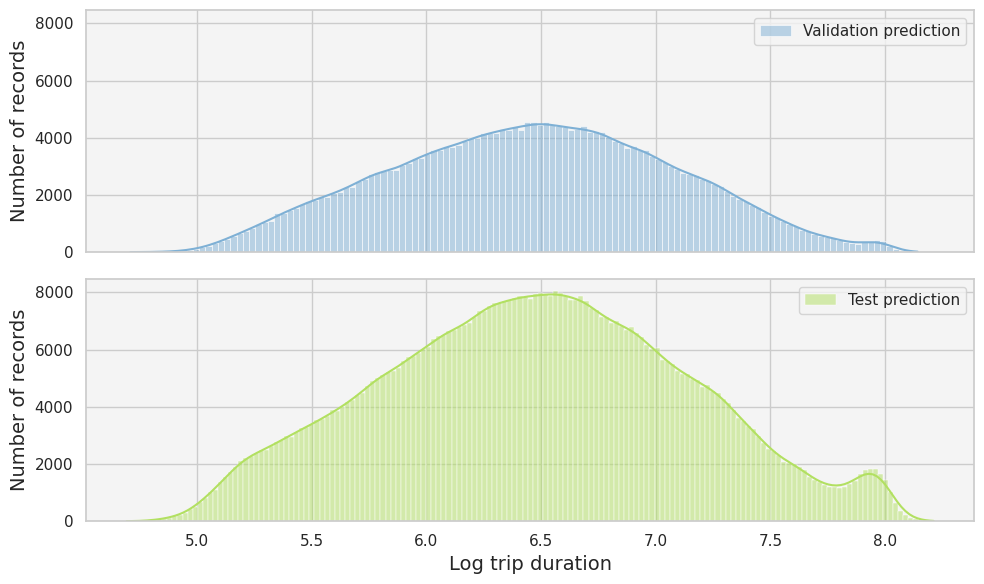

In [115]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)

sns.histplot(y_predictions, ax=ax[0], kde=True, color='#7eb0d5', label='Validation prediction')
sns.histplot(y_test, ax=ax[1], kde=True, color='#b2e061', label='Test prediction')

ax[0].set_ylabel('Number of records', fontsize=14)
ax[1].set_ylabel('Number of records', fontsize=14)

ax[0].set_xlabel('Log trip duration', fontsize=14)
ax[1].set_xlabel('Log trip duration', fontsize=14)

ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(data_path, 'images', 'val_test.png'))

In [116]:
test[['id', 'trip_duration']].head()

,id,trip_duration
0,id3004672,831.095398
1,id3505355,629.671448
2,id1217141,444.918762
3,id2150126,853.307190
4,id1598245,336.344635


In [117]:
print(f'Mean predicted trip duration - {test["trip_duration"].mean() / 60.0:.2f} mins')

Mean predicted trip duration - 13.43 mins
